# Downloading Libraries

In [1]:
pip install -q datasets wandb evaluate optuna onnxruntime

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import warnings
from collections import Counter
from pathlib import Path
from time import perf_counter

import numpy as np
import optuna
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb

from datasets import load_dataset
from matplotlib import pyplot as plt
from onnxruntime import GraphOptimizationLevel, InferenceSession, SessionOptions
from psutil import cpu_count
from scipy.special import softmax
from sklearn.metrics import accuracy_score, f1_score
from torch.quantization import quantize_dynamic
from tqdm import tqdm
from transformers import (AutoConfig, AutoModelForSequenceClassification,
                          AutoTokenizer, Trainer, TrainingArguments, pipeline)
from transformers.convert_graph_to_onnx import convert
# Ignore all warnings
warnings.filterwarnings("ignore")
wandb.login(key="your_wandb_key")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
!huggingface-cli login --token your_huggingface_token

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


# Creating a Performance Benchmark

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model_ckpt="HuggingPanda/bert-base-uncased-finetuned-clinc_oos-plus"
pipe = pipeline("text-classification",model=model_ckpt, device="cpu")

cpu


config.json:   0%|          | 0.00/8.32k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [5]:
from evaluate import load

dataset = load_dataset("clinc_oos", "plus")
accuracy_score=load("accuracy")

dataset

README.md:   0%|          | 0.00/24.0k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/312k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/77.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/136k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15250 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'intent'],
        num_rows: 15250
    })
    validation: Dataset({
        features: ['text', 'intent'],
        num_rows: 3100
    })
    test: Dataset({
        features: ['text', 'intent'],
        num_rows: 5500
    })
})

In [6]:
intents=dataset['test'].features['intent']

In [7]:
class PerformanceBenchmark:
  def __init__(self, pipeline, dataset, optim_type="BERT Baseline"):
    self.pipeline=pipeline
    self.dataset=dataset
    self.optim_type=optim_type

  def compute_accuracy(self):
    preds, labels = [], []
    for example in self.dataset:
        pred = self.pipeline(example["text"])[0]["label"]
        label = example["intent"]
        preds.append(intents.str2int(pred))
        labels.append(label)
    accuracy = accuracy_score.compute(predictions=preds, references=labels)
    print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
    return accuracy


  def compute_size(self):
    state_dict=self.pipeline.model.state_dict()

    tmp_path=Path("model.pt")
    torch.save(state_dict,tmp_path)
    size_mb=Path(tmp_path).stat().st_size/(1024*1024)
    tmp_path.unlink()

    print(f"Model size (MB) - {size_mb:.2f}")
    return {"size_mb":size_mb}

  def time_pipeline(self, query="What is the pin number for my account"):
    latencies = []

    #Warmup
    for _ in range(10):
      _ = self.pipeline(query)

    # Timed run
    for _ in range(1000):
      start_time=perf_counter()
      _ = self.pipeline(query)
      latency=perf_counter() - start_time
      latencies.append(latency)

    #Compute run statistics
    time_avg_ms = 1000 * np.mean(latencies)
    time_std_ms = 1000 * np.std(latencies)
    print(f"Average latency (ms) - {time_avg_ms:.2f} +\-{time_std_ms:.2f}")

    return {
        "time_avg_ms":time_avg_ms,
        "time_std_ms":time_std_ms
    }

  def run_benchmark(self):
    metrics={}

    metrics[self.optim_type]=self.compute_size()
    metrics[self.optim_type].update(self.time_pipeline())
    metrics[self.optim_type].update(self.compute_accuracy())

    return metrics

In [8]:
pb = PerformanceBenchmark(pipe,dataset['test'])
perf_metrics = pb.run_benchmark()

Model size (MB) - 418.15
Average latency (ms) - 54.08 +\-7.14
Accuracy on test set - 0.869


# Finetuning DistillBERT

In [9]:
class DistillationTrainingArguments(TrainingArguments):

  def __init__(self,*args, alpha=0.5, temperature=2, **kwargs):
    super().__init__(*args,**kwargs)
    self.alpha=alpha
    self.temperature=temperature

In [10]:
class DistillationTrainer(Trainer):
  def __init__(self, *args, teacher_model=None, **kwargs):
    super().__init__(*args,**kwargs)
    self.teacher_model=teacher_model

  def compute_loss(self, model, inputs, return_outputs=False):
    outputs_stu = model(**inputs)
    loss_ce = outputs_stu.loss
    logits_stu = outputs_stu.logits

    with torch.no_grad():
      outputs_tea = self.teacher_model(**inputs)
      logits_tea = outputs_tea.logits

    loss_fct = nn.KLDivLoss(reduction="batchmean")
    loss_kd = self.args.temperature ** 2 * loss_fct(
        F.log_softmax(logits_stu / self.args.temperature, dim=-1),
        F.softmax(logits_tea / self.args.temperature, dim=-1)
    )

    loss = self.args.alpha * loss_ce + (1 - self.args.alpha) * loss_kd
    return (loss, outputs_stu) if return_outputs else loss

In [11]:
model_ckpt = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize_text(batch):
  return student_tokenizer(batch["text"], truncation=True)

tokenized_datasets = dataset.map(tokenize_text, batched=True, remove_columns=["text"])
tokenized_datasets = tokenized_datasets.rename_column("intent", "labels")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/15250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3100 [00:00<?, ? examples/s]

Map:   0%|          | 0/5500 [00:00<?, ? examples/s]

In [12]:
def compute_metrics(eval_pred):
  logits, labels = eval_pred
  preds = np.argmax(logits, axis=-1)
  acc = accuracy_score.compute(predictions=preds, references=labels)
  return acc

In [13]:
batch_size = 48
student_ckpt = "distilbert-base-uncased"
finetuned_ckpt = f"{student_ckpt}-finetuned-clinc-oos-plus"
logging_steps = len(tokenized_datasets["train"]) // (batch_size*2)

In [14]:
student_training_args = DistillationTrainingArguments(output_dir=finetuned_ckpt,
                                  num_train_epochs=12,
                                  learning_rate=4e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  alpha=1,
                                  evaluation_strategy="steps",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  eval_steps=logging_steps,
                                  save_steps=logging_steps,
                                  save_total_limit=1,
                                  load_best_model_at_end=True,
                                  push_to_hub=True,
                                  log_level="error")

In [15]:
id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id

In [16]:
num_labels= intents.num_classes
student_config = AutoConfig.from_pretrained(student_ckpt, num_labels=num_labels, id2label=id2label, label2id=label2id)

In [17]:
def student_init():
  return AutoModelForSequenceClassification.from_config(student_config).to(device)

In [18]:
teacher_ckpt = "HuggingPanda/bert-base-uncased-finetuned-clinc_oos-plus"

teacher_model= AutoModelForSequenceClassification.from_pretrained(teacher_ckpt, num_labels=num_labels).to(device)

In [19]:
distill_trainer = DistillationTrainer(
    model_init=student_init,
    teacher_model=teacher_model,
    args=student_training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
    tokenizer=student_tokenizer
)

In [48]:
distill_trainer.train()

Step,Training Loss,Validation Loss,Accuracy
158,4.575600,3.438506,0.504194
316,2.218200,1.246597,0.785161
474,0.879300,0.741575,0.843871
632,0.475000,0.598588,0.861935
790,0.291100,0.503923,0.880000
948,0.190800,0.463486,0.887419
1106,0.129200,0.459182,0.886774
1264,0.089300,0.457525,0.887742
1422,0.067800,0.453535,0.889677
1580,0.050700,0.452015,0.889355


TrainOutput(global_step=1908, training_loss=0.7492208379150936, metrics={'train_runtime': 618.3724, 'train_samples_per_second': 295.938, 'train_steps_per_second': 3.086, 'total_flos': 1065443953668864.0, 'train_loss': 0.7492208379150936, 'epoch': 12.0})

In [18]:
pipe = pipeline("text-classification", model="HuggingPanda/"+finetuned_ckpt,device="cpu")

optim_type="DistilBERT"
pb=PerformanceBenchmark(pipe,dataset['test'],optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

config.json:   0%|          | 0.00/8.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Model size (MB) - 255.88
Average latency (ms) - 29.65 +\-3.73
Accuracy on test set - 0.816


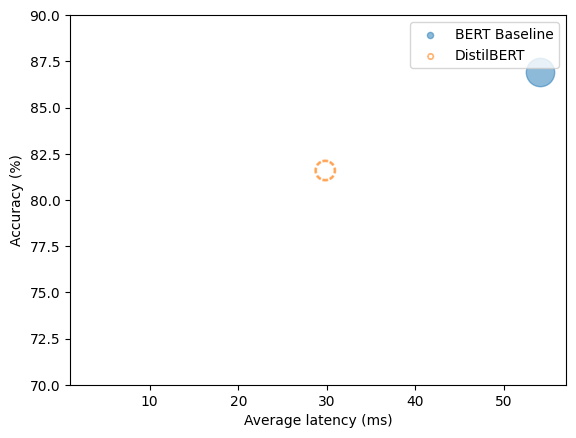

In [19]:
def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient='index')

    for idx in df.index:
        df_opt = df.loc[idx]
        # Add a dashed circle around the current optimization type
        if idx == current_optim_type:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                        alpha=0.5, s=df_opt["size_mb"], label=idx,
                        marker='$\u25CC$')
        else:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                        s=df_opt["size_mb"], label=idx, alpha=0.5)

    legend = plt.legend(bbox_to_anchor=(1,1))
    for handle in legend.legendHandles:
        handle.set_sizes([20])

    plt.ylim(70,90)
    # Use the slowest model to define the x-axis range
    xlim = int(perf_metrics["BERT Baseline"]["time_avg_ms"] + 3)
    plt.xlim(1, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()

plot_metrics(perf_metrics, optim_type)

# Find Best Hyperparameters For Training

In [51]:
def hp_space(trail):
  return {
      "num_train_epochs":trail.suggest_int("num_train_epochs",8,15),
      "alpha": trail.suggest_float("alpha",0,1),
      "temperature": trail.suggest_int("temperature",2,10)
  }

setattr(student_training_args, "push_to_hub", False)

best_run=distill_trainer.hyperparameter_search(n_trials=40, direction="maximize", hp_space=hp_space)
print(best_run)

2024-10-11 05:06:47,676	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
[I 2024-10-11 05:06:47,695] A new study created in memory with name: no-name-5c539f1c-8560-47b6-a596-1c2ba43cd8d3


eval/accuracy,▃▇▇█████████▁▆▇▇█████▁▆▇██████▁▆▇███████
eval/loss,▆▂▁▁▁▁▁▁▁▁▁▁█▃▂▁▁▁▁▁▁█▃▂▁▁▁▁▁▁█▃▁▁▁▁▁▁▁▁
eval/runtime,▁▃▁▂█▂▂▂▂▂▂▂▅▄▄▅▄▄▄▅▄▄▅▄▄▄▄▄▄▄▄▅▅▄▄▄▄▄▄▅
eval/samples_per_second,█▆█▇▁▇▇▇▇▇▇▇▄▅▅▄▅▅▅▄▅▅▄▅▅▅▅▅▅▅▅▄▄▅▅▅▅▄▅▄
eval/steps_per_second,████▇███████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch,▁▂▂▂▃▅▅▆▇▇█▂▃▃▃▅▁▁▂▂▃▃▃▄▄▆▆▁▁▂▃▄▄▄▅▆▆▆▇▇
train/global_step,▁▂▂▃▃▅▅▇▇█▁▂▂▃▃▄▄▁▂▂▃▃▃▄▄▄▁▂▂▂▃▃▃▄▄▄▄▅▅▅
train/grad_norm,█▇█▆▆▅▅▃▃▁▂▁▆▇▆▇▄▄▄▃▃▆▇▆▅▄▄▄▃▃▆▇▇▅▄▄▃▃▂▂
train/learning_rate,█▇▇▆▆▅▅▄▃▃▂▂█▇▆▆▄▃▃▂▁█▇▆▅▄▃▃▂▁█▇▆▅▅▄▄▃▂▁
train/loss,█▃▂▁▁▁▁▁▁▁▁▁█▄▂▂▁▁▁▁▁█▄▂▁▁▁▁▁▁█▄▂▁▁▁▁▁▁▁
eval/accuracy,0.8929


Step,Training Loss,Validation Loss,Accuracy
158,0.626100,0.447695,0.185484
316,0.372300,0.256704,0.637742
474,0.238600,0.185819,0.751613
632,0.180000,0.152628,0.779032
790,0.146300,0.133594,0.799677
948,0.123200,0.121538,0.814194
1106,0.107900,0.113018,0.828387
1264,0.096000,0.106377,0.833226
1422,0.087400,0.101235,0.842258
1580,0.081700,0.098938,0.848710


[I 2024-10-11 05:18:48,428] Trial 0 finished with value: 0.853225806451613 and parameters: {'num_train_epochs': 14, 'alpha': 0.14161058751906408, 'temperature': 9}. Best is trial 0 with value: 0.853225806451613.


eval/accuracy,▁▆▇▇▇█████████
eval/loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁
eval/runtime,▁▂▁▁▁▁▂▁█▂▁▁▁▁
eval/samples_per_second,█▇████▇█▁▇████
eval/steps_per_second,█▇████▇█▁▇████
train/epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train/global_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train/grad_norm,▇█▇▇▃▃▂▁▂▂▁▁▁▂
train/learning_rate,█▇▇▆▆▅▅▄▄▃▃▂▂▁
train/loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁
eval/accuracy,0.85323


Step,Training Loss,Validation Loss,Accuracy
158,0.616700,0.439565,0.185161
316,0.367200,0.253968,0.627097
474,0.235600,0.183948,0.752903
632,0.177700,0.151094,0.773871
790,0.144200,0.131991,0.797097
948,0.121000,0.120118,0.814516
1106,0.105700,0.111527,0.827419
1264,0.093700,0.104493,0.835806
1422,0.084900,0.099191,0.841613
1580,0.079000,0.096693,0.849355


[I 2024-10-11 05:31:39,542] Trial 1 finished with value: 0.8561290322580645 and parameters: {'num_train_epochs': 15, 'alpha': 0.5561233548213954, 'temperature': 10}. Best is trial 1 with value: 0.8561290322580645.


eval/accuracy,▁▆▇▇▇██████████
eval/loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁
eval/runtime,▁▂▂▂▂▂▂▂█▂▂▁▁▁▁
eval/samples_per_second,█▇▇▇▇▇▇▇▁▇▇████
eval/steps_per_second,█▇▇▇▇▇▇▇▁▇▇████
train/epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train/grad_norm,▇█▇▇▃▄▃▂▃▂▂▂▂▂▁
train/learning_rate,█▇▇▆▆▅▅▄▄▃▃▂▂▁▁
train/loss,█▅▃▂▂▂▂▁▁▁▁▁▁▁▁
eval/accuracy,0.85613


Step,Training Loss,Validation Loss,Accuracy
158,0.627200,0.451332,0.180323
316,0.378200,0.263970,0.618710
474,0.247100,0.192834,0.743226
632,0.190100,0.160503,0.771613
790,0.158000,0.142995,0.786774
948,0.137000,0.130528,0.805161
1106,0.124300,0.124922,0.818387
1264,0.115200,0.120753,0.820323
1422,0.110300,0.119152,0.821613


[I 2024-10-11 05:39:25,229] Trial 2 finished with value: 0.8216129032258065 and parameters: {'num_train_epochs': 9, 'alpha': 0.2810690903860511, 'temperature': 9}. Best is trial 1 with value: 0.8561290322580645.


eval/accuracy,▁▆▇▇█████
eval/loss,█▄▃▂▂▁▁▁▁
eval/runtime,▁▇▄▃█▁▂▄▇
eval/samples_per_second,█▂▅▆▁█▇▅▂
eval/steps_per_second,▇▂▅▆▁█▇▅▂
train/epoch,▁▁▂▂▃▃▄▄▄▄▅▅▆▆▇▇███
train/global_step,▁▁▂▂▃▃▄▄▄▄▅▅▆▆▇▇███
train/grad_norm,▆█▇▅▄▃▂▁▂
train/learning_rate,█▇▆▅▅▄▃▂▁
train/loss,█▅▃▂▂▁▁▁▁
eval/accuracy,0.82161


Step,Training Loss,Validation Loss,Accuracy
158,0.719900,0.507902,0.248710
316,0.419300,0.277720,0.678710
474,0.260600,0.197866,0.765161
632,0.194200,0.162167,0.790000
790,0.157100,0.142793,0.808710
948,0.132300,0.129030,0.823548
1106,0.116400,0.121383,0.836452
1264,0.104200,0.115192,0.837097
1422,0.095700,0.110242,0.848387
1580,0.090600,0.108126,0.848387


[I 2024-10-11 05:49:43,323] Trial 3 finished with value: 0.8519354838709677 and parameters: {'num_train_epochs': 12, 'alpha': 0.8878249938721112, 'temperature': 5}. Best is trial 1 with value: 0.8561290322580645.


eval/accuracy,▁▆▇▇▇███████
eval/loss,█▄▃▂▂▁▁▁▁▁▁▁
eval/runtime,▅▃▂█▄▃▆▄▃▁▃▃
eval/samples_per_second,▄▅▇▁▅▆▃▅▆█▆▆
eval/steps_per_second,▃▆▇▁▅▆▃▅▆█▆▆
train/epoch,▁▁▂▂▂▂▃▃▄▄▄▄▅▅▅▅▆▆▇▇▇▇███
train/global_step,▁▁▂▂▂▂▃▃▄▄▄▄▅▅▅▅▆▆▇▇▇▇███
train/grad_norm,▄█▆▆▃▃▂▁▂▂▁▁
train/learning_rate,█▇▇▆▅▅▄▄▃▂▂▁
train/loss,█▅▃▂▂▂▁▁▁▁▁▁
eval/accuracy,0.85194


Step,Training Loss,Validation Loss,Accuracy
158,0.935700,0.644917,0.374194
316,0.516300,0.321395,0.711935
474,0.305800,0.225036,0.778387
632,0.224900,0.185208,0.803548
790,0.181800,0.164453,0.817097
948,0.154300,0.150016,0.831935
1106,0.138000,0.143424,0.839032
1264,0.126600,0.138559,0.839032
1422,0.120600,0.136774,0.845161


[I 2024-10-11 05:57:28,664] Trial 4 finished with value: 0.8451612903225807 and parameters: {'num_train_epochs': 9, 'alpha': 0.9413077610063327, 'temperature': 3}. Best is trial 1 with value: 0.8561290322580645.


eval/accuracy,▁▆▇▇█████
eval/loss,█▄▂▂▁▁▁▁▁
eval/runtime,▂██▆▁▃▇▄▄
eval/samples_per_second,▇▁▁▃█▆▂▅▅
eval/steps_per_second,▆▁▁▃█▆▂▅▅
train/epoch,▁▁▂▂▃▃▄▄▄▄▅▅▆▆▇▇███
train/global_step,▁▁▂▂▃▃▄▄▄▄▅▅▆▆▇▇███
train/grad_norm,▆█▇▆▄▃▂▁▂
train/learning_rate,█▇▆▅▅▄▃▂▁
train/loss,█▄▃▂▂▁▁▁▁
eval/accuracy,0.84516


Step,Training Loss,Validation Loss,Accuracy
158,0.626000,0.447396,0.183548


[I 2024-10-11 05:58:22,700] Trial 5 pruned. 


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/grad_norm,▁
train/learning_rate,▁
train/loss,▁
eval/accuracy,0.18355


Step,Training Loss,Validation Loss,Accuracy
158,0.639100,0.455834,0.192258
316,0.380700,0.262282,0.640968
474,0.245200,0.190288,0.752258


[I 2024-10-11 06:00:58,202] Trial 6 pruned. 


eval/accuracy,▁▇█
eval/loss,█▃▁
eval/runtime,█▁▁
eval/samples_per_second,▁██
eval/steps_per_second,▁██
train/epoch,▁▁▅▅██
train/global_step,▁▁▅▅██
train/grad_norm,▂█▁
train/learning_rate,█▄▁
train/loss,█▃▁
eval/accuracy,0.75226


Step,Training Loss,Validation Loss,Accuracy
158,0.626900,0.449543,0.184516


[I 2024-10-11 06:01:52,163] Trial 7 pruned. 


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/grad_norm,▁
train/learning_rate,▁
train/loss,▁
eval/accuracy,0.18452


Step,Training Loss,Validation Loss,Accuracy
158,0.680000,0.481379,0.230323
316,0.400000,0.270418,0.661290
474,0.253700,0.194958,0.756129
632,0.191400,0.160745,0.787742
790,0.156300,0.142200,0.803226
948,0.132900,0.128373,0.818710
1106,0.117800,0.121307,0.831613
1264,0.106500,0.115624,0.832581


[I 2024-10-11 06:08:42,523] Trial 8 pruned. 


eval/accuracy,▁▆▇▇████
eval/loss,█▄▃▂▂▁▁▁
eval/runtime,▇▆▃▁█▆▁▅
eval/samples_per_second,▂▃▆█▁▃█▄
eval/steps_per_second,▂▃▆█▁▃█▄
train/epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
train/global_step,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
train/grad_norm,▆█▇▇▃▃▂▁
train/learning_rate,█▇▆▅▄▃▂▁
train/loss,█▅▃▂▂▁▁▁
eval/accuracy,0.83258


Step,Training Loss,Validation Loss,Accuracy
158,0.655900,0.466177,0.207419
316,0.388900,0.266279,0.647419
474,0.249200,0.192216,0.754516
632,0.188700,0.159017,0.781613
790,0.154600,0.140594,0.801290
948,0.131700,0.127091,0.815806
1106,0.116900,0.120019,0.826774


[I 2024-10-11 06:14:41,671] Trial 9 pruned. 


eval/accuracy,▁▆▇▇███
eval/loss,█▄▂▂▁▁▁
eval/runtime,▂▄▄▅█▁▄
eval/samples_per_second,▇▅▅▃▁█▅
eval/steps_per_second,▇▅▅▃▁█▅
train/epoch,▁▁▂▂▃▃▄▄▆▆▇▇██
train/global_step,▁▁▂▂▃▃▅▅▆▆▇▇██
train/grad_norm,▅█▆▆▂▂▁
train/learning_rate,█▇▆▄▃▂▁
train/loss,█▅▃▂▁▁▁
eval/accuracy,0.82677


Step,Training Loss,Validation Loss,Accuracy
158,0.934800,0.641677,0.377742
316,0.506700,0.309332,0.718387
474,0.292200,0.215253,0.784194
632,0.209700,0.174833,0.814839
790,0.164800,0.152049,0.828387
948,0.134900,0.138170,0.840968
1106,0.115900,0.128586,0.852903
1264,0.101500,0.121065,0.851935
1422,0.091600,0.115195,0.861613
1580,0.085000,0.112898,0.862581


[I 2024-10-11 06:27:32,926] Trial 10 finished with value: 0.8722580645161291 and parameters: {'num_train_epochs': 15, 'alpha': 0.505102552493356, 'temperature': 3}. Best is trial 10 with value: 0.8722580645161291.


eval/accuracy,▁▆▇▇▇██████████
eval/loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁
eval/runtime,▁▆▃▁▄█▃▇▅▃▃▆▅▃▇
eval/samples_per_second,█▃▆█▅▁▆▂▄▆▆▃▄▆▂
eval/steps_per_second,█▃▆█▅▁▆▂▄▆▆▃▄▆▂
train/epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train/grad_norm,▇█▇▇▄▄▃▃▃▃▂▂▂▂▁
train/learning_rate,█▇▇▆▆▅▅▄▄▃▃▂▂▁▁
train/loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁
eval/accuracy,0.87226


Step,Training Loss,Validation Loss,Accuracy
158,1.367800,0.883720,0.470645
316,0.662500,0.373190,0.741290
474,0.352200,0.256462,0.795484
632,0.246200,0.210722,0.828387
790,0.189500,0.181782,0.844839
948,0.151400,0.165397,0.859677
1106,0.127700,0.153609,0.866452
1264,0.110500,0.143951,0.867097
1422,0.099100,0.136611,0.876129
1580,0.091100,0.134545,0.875484


[I 2024-10-11 06:40:26,644] Trial 11 finished with value: 0.88 and parameters: {'num_train_epochs': 15, 'alpha': 0.6035619778723638, 'temperature': 2}. Best is trial 11 with value: 0.88.


eval/accuracy,▁▆▇▇▇██████████
eval/loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
eval/runtime,▅█▁▅▄▃▆▄▆▃▇▆▅▆▅
eval/samples_per_second,▄▁█▄▅▆▃▅▃▆▂▃▄▃▄
eval/steps_per_second,▄▁█▄▅▆▃▅▃▅▂▃▄▃▄
train/epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train/grad_norm,▆██▇▄▄▃▃▃▂▃▂▂▂▁
train/learning_rate,█▇▇▆▆▅▅▄▄▃▃▂▂▁▁
train/loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁
eval/accuracy,0.88


Step,Training Loss,Validation Loss,Accuracy
158,1.369500,0.885960,0.474839
316,0.665500,0.376032,0.736129
474,0.354400,0.258366,0.794839
632,0.248200,0.211549,0.825484
790,0.191300,0.182958,0.842903
948,0.153400,0.166456,0.856774
1106,0.129900,0.154824,0.866129
1264,0.112800,0.145605,0.866129
1422,0.101500,0.138381,0.873871
1580,0.093900,0.136591,0.875484


[I 2024-10-11 06:52:28,748] Trial 12 finished with value: 0.8787096774193548 and parameters: {'num_train_epochs': 14, 'alpha': 0.7157273703542387, 'temperature': 2}. Best is trial 11 with value: 0.88.


eval/accuracy,▁▆▇▇▇█████████
eval/loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁
eval/runtime,▅█▂▄▇▇▄▃▁▇▃█▆▃
eval/samples_per_second,▄▁▇▅▂▂▅▆█▂▆▁▃▆
eval/steps_per_second,▄▁▇▆▂▂▅▆█▂▆▁▃▆
train/epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train/global_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train/grad_norm,▆█▇▇▄▄▂▂▂▁▁▁▁▁
train/learning_rate,█▇▇▆▆▅▅▄▄▃▃▂▂▁
train/loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁
eval/accuracy,0.87871


Step,Training Loss,Validation Loss,Accuracy
158,1.368900,0.888800,0.475161
316,0.667100,0.377212,0.740000
474,0.356600,0.259315,0.794516
632,0.250300,0.213203,0.824839
790,0.193800,0.185087,0.840645
948,0.156300,0.168176,0.858065
1106,0.132800,0.157134,0.863548
1264,0.116000,0.147884,0.866129
1422,0.104800,0.140960,0.872581
1580,0.097400,0.139060,0.875161


[I 2024-10-11 07:03:39,749] Trial 13 finished with value: 0.8764516129032258 and parameters: {'num_train_epochs': 13, 'alpha': 0.7382074890366195, 'temperature': 2}. Best is trial 11 with value: 0.88.


eval/accuracy,▁▆▇▇▇████████
eval/loss,█▃▂▂▁▁▁▁▁▁▁▁▁
eval/runtime,▂▆▂▄▄▁▄▆▄▁▂█▅
eval/samples_per_second,▇▂▇▅▅█▅▃▅█▇▁▄
eval/steps_per_second,█▂▇▅▅█▅▃▅█▇▁▄
train/epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▆▆▆▆▇▇▇▇███
train/global_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▆▆▆▆▇▇▇▇███
train/grad_norm,▆██▇▄▄▂▂▂▂▁▁▁
train/learning_rate,█▇▇▆▆▅▅▄▃▃▂▂▁
train/loss,█▄▂▂▂▁▁▁▁▁▁▁▁
eval/accuracy,0.87645


Step,Training Loss,Validation Loss,Accuracy
158,0.789400,0.552428,0.305484


[I 2024-10-11 07:04:34,035] Trial 14 pruned. 


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/grad_norm,▁
train/learning_rate,▁
train/loss,▁
eval/accuracy,0.30548


Step,Training Loss,Validation Loss,Accuracy
158,1.369500,0.885960,0.474839
316,0.665500,0.376032,0.736129
474,0.354400,0.258366,0.794839
632,0.248200,0.211549,0.825484
790,0.191300,0.182958,0.842903
948,0.153400,0.166456,0.856774
1106,0.129900,0.154824,0.866129
1264,0.112800,0.145605,0.866129
1422,0.101500,0.138381,0.873871
1580,0.093900,0.136591,0.875484


[I 2024-10-11 07:16:33,846] Trial 15 finished with value: 0.8787096774193548 and parameters: {'num_train_epochs': 14, 'alpha': 0.41998368351060655, 'temperature': 2}. Best is trial 11 with value: 0.88.


eval/accuracy,▁▆▇▇▇█████████
eval/loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁
eval/runtime,▇▃▄▂▄▅▄█▅▁▃▅▅▆
eval/samples_per_second,▂▆▅▇▅▄▅▁▄█▆▄▄▃
eval/steps_per_second,▂▆▅▇▅▄▅▁▄█▆▄▄▃
train/epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train/global_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train/grad_norm,▆█▇▇▄▄▂▂▂▁▁▁▁▁
train/learning_rate,█▇▇▆▆▅▅▄▄▃▃▂▂▁
train/loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁
eval/accuracy,0.87871


Step,Training Loss,Validation Loss,Accuracy
158,0.790000,0.553380,0.292581


[I 2024-10-11 07:17:28,137] Trial 16 pruned. 


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/grad_norm,▁
train/learning_rate,▁
train/loss,▁
eval/accuracy,0.29258


Step,Training Loss,Validation Loss,Accuracy
158,1.367800,0.883720,0.470645
316,0.662500,0.373190,0.741290
474,0.352200,0.256462,0.795484
632,0.246200,0.210722,0.828387
790,0.189500,0.181782,0.844839
948,0.151400,0.165397,0.859677
1106,0.127700,0.153609,0.866452
1264,0.110500,0.143951,0.867097
1422,0.099100,0.136611,0.876129
1580,0.091100,0.134545,0.875484


[I 2024-10-11 07:30:19,163] Trial 17 finished with value: 0.88 and parameters: {'num_train_epochs': 15, 'alpha': 0.4338537622215186, 'temperature': 2}. Best is trial 11 with value: 0.88.


eval/accuracy,▁▆▇▇▇██████████
eval/loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
eval/runtime,▂█▅▂▁▄▄▂▄▇▄▄▃▁▅
eval/samples_per_second,▇▁▄▇█▅▅▇▅▂▅▅▆█▄
eval/steps_per_second,▇▁▄▇█▅▅▇▅▂▅▅▆█▄
train/epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train/grad_norm,▆██▇▄▄▃▃▃▂▃▂▂▂▁
train/learning_rate,█▇▇▆▆▅▅▄▄▃▃▂▂▁▁
train/loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁
eval/accuracy,0.88


Step,Training Loss,Validation Loss,Accuracy
158,0.789800,0.551875,0.297097


[I 2024-10-11 07:31:13,228] Trial 18 pruned. 


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/grad_norm,▁
train/learning_rate,▁
train/loss,▁
eval/accuracy,0.2971


Step,Training Loss,Validation Loss,Accuracy
158,0.681300,0.484664,0.219032


[I 2024-10-11 07:32:07,327] Trial 19 pruned. 


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/grad_norm,▁
train/learning_rate,▁
train/loss,▁
eval/accuracy,0.21903


Step,Training Loss,Validation Loss,Accuracy
158,0.934600,0.641234,0.369677


[I 2024-10-11 07:33:02,098] Trial 20 pruned. 


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/grad_norm,▁
train/learning_rate,▁
train/loss,▁
eval/accuracy,0.36968


Step,Training Loss,Validation Loss,Accuracy
158,1.367800,0.883720,0.470645
316,0.662500,0.373190,0.741290
474,0.352200,0.256462,0.795484
632,0.246200,0.210722,0.828387
790,0.189500,0.181782,0.844839
948,0.151400,0.165397,0.859677
1106,0.127700,0.153609,0.866452
1264,0.110500,0.143951,0.867097
1422,0.099100,0.136611,0.876129
1580,0.091100,0.134545,0.875484


[I 2024-10-11 07:45:53,353] Trial 21 finished with value: 0.88 and parameters: {'num_train_epochs': 15, 'alpha': 0.6089610473117106, 'temperature': 2}. Best is trial 11 with value: 0.88.


eval/accuracy,▁▆▇▇▇██████████
eval/loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
eval/runtime,▁▆▃▅▃▃▆▅▆▆▆█▅▅▅
eval/samples_per_second,█▃▆▄▆▆▃▄▃▂▃▁▄▃▄
eval/steps_per_second,█▃▆▄▆▆▃▄▃▃▃▁▄▄▄
train/epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train/grad_norm,▆██▇▄▄▃▃▃▂▃▂▂▂▁
train/learning_rate,█▇▇▆▆▅▅▄▄▃▃▂▂▁▁
train/loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁
eval/accuracy,0.88


Step,Training Loss,Validation Loss,Accuracy
158,1.367800,0.883720,0.470645
316,0.662500,0.373190,0.741290
474,0.352200,0.256462,0.795484
632,0.246200,0.210722,0.828387
790,0.189500,0.181782,0.844839
948,0.151400,0.165397,0.859677
1106,0.127700,0.153609,0.866452
1264,0.110500,0.143951,0.867097
1422,0.099100,0.136611,0.876129
1580,0.091100,0.134545,0.875484


[I 2024-10-11 07:58:44,047] Trial 22 finished with value: 0.88 and parameters: {'num_train_epochs': 15, 'alpha': 0.5762662568274641, 'temperature': 2}. Best is trial 11 with value: 0.88.


eval/accuracy,▁▆▇▇▇██████████
eval/loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
eval/runtime,▄▆▂▄▂▂▆▂▄▄▂▇▁▅█
eval/samples_per_second,▅▃▇▅▇▇▃▇▅▅▇▂█▄▁
eval/steps_per_second,▆▃▇▅▇▇▃▇▅▅▇▂█▄▁
train/epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train/grad_norm,▆██▇▄▄▃▃▃▂▃▂▂▂▁
train/learning_rate,█▇▇▆▆▅▅▄▄▃▃▂▂▁▁
train/loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁
eval/accuracy,0.88


Step,Training Loss,Validation Loss,Accuracy
158,0.934800,0.641677,0.377742


[I 2024-10-11 07:59:38,316] Trial 23 pruned. 


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/grad_norm,▁
train/learning_rate,▁
train/loss,▁
eval/accuracy,0.37774


Step,Training Loss,Validation Loss,Accuracy
158,0.719500,0.506059,0.253226


[I 2024-10-11 08:00:32,302] Trial 24 pruned. 


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/grad_norm,▁
train/learning_rate,▁
train/loss,▁
eval/accuracy,0.25323


Step,Training Loss,Validation Loss,Accuracy
158,1.368900,0.888800,0.475161
316,0.667100,0.377212,0.740000
474,0.356600,0.259315,0.794516
632,0.250300,0.213203,0.824839
790,0.193800,0.185087,0.840645
948,0.156300,0.168176,0.858065
1106,0.132800,0.157134,0.863548
1264,0.116000,0.147884,0.866129
1422,0.104800,0.140960,0.872581
1580,0.097400,0.139060,0.875161


[I 2024-10-11 08:09:03,266] Trial 25 pruned. 


eval/accuracy,▁▆▇▇▇█████
eval/loss,█▃▂▂▁▁▁▁▁▁
eval/runtime,▁▁▁▁▁▁▁▁█▁
eval/samples_per_second,████████▁█
eval/steps_per_second,████████▁█
train/epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
train/global_step,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
train/grad_norm,▆██▇▃▃▂▁▁▁
train/learning_rate,█▇▆▆▅▄▃▃▂▁
train/loss,█▄▂▂▂▁▁▁▁▁
eval/accuracy,0.87516


Step,Training Loss,Validation Loss,Accuracy
158,0.935300,0.639935,0.385161


[I 2024-10-11 08:09:57,281] Trial 26 pruned. 


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/grad_norm,▁
train/learning_rate,▁
train/loss,▁
eval/accuracy,0.38516


Step,Training Loss,Validation Loss,Accuracy
158,0.789800,0.551875,0.297097


[I 2024-10-11 08:10:51,152] Trial 27 pruned. 


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/grad_norm,▁
train/learning_rate,▁
train/loss,▁
eval/accuracy,0.2971


Step,Training Loss,Validation Loss,Accuracy
158,0.719500,0.506059,0.253226


[I 2024-10-11 08:11:45,334] Trial 28 pruned. 


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/grad_norm,▁
train/learning_rate,▁
train/loss,▁
eval/accuracy,0.25323


Step,Training Loss,Validation Loss,Accuracy
158,1.369500,0.885960,0.474839
316,0.665500,0.376032,0.736129
474,0.354400,0.258366,0.794839
632,0.248200,0.211549,0.825484
790,0.191300,0.182958,0.842903
948,0.153400,0.166456,0.856774
1106,0.129900,0.154824,0.866129
1264,0.112800,0.145605,0.866129
1422,0.101500,0.138381,0.873871
1580,0.093900,0.136591,0.875484


[I 2024-10-11 08:22:48,579] Trial 29 pruned. 


eval/accuracy,▁▆▇▇▇████████
eval/loss,█▃▂▂▁▁▁▁▁▁▁▁▁
eval/runtime,▃▅▃▂▄▁█▂▂▂▁▃█
eval/samples_per_second,▆▄▆▇▅█▁▇▇▇█▆▁
eval/steps_per_second,▆▄▆▇▅█▁█▇▇█▆▁
train/epoch,▁▁▂▂▂▂▃▃▃▃▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
train/global_step,▁▁▂▂▂▂▃▃▃▃▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
train/grad_norm,▆█▇▇▄▄▂▂▂▁▁▁▁
train/learning_rate,█▇▇▆▆▅▅▄▃▃▂▂▁
train/loss,█▄▂▂▂▁▁▁▁▁▁▁▁
eval/accuracy,0.87613


Step,Training Loss,Validation Loss,Accuracy
158,0.934800,0.641677,0.377742


[I 2024-10-11 08:23:42,703] Trial 30 pruned. 


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/grad_norm,▁
train/learning_rate,▁
train/loss,▁
eval/accuracy,0.37774


Step,Training Loss,Validation Loss,Accuracy
158,1.367800,0.883720,0.470645
316,0.662500,0.373190,0.741290
474,0.352200,0.256462,0.795484
632,0.246200,0.210722,0.828387
790,0.189500,0.181782,0.844839
948,0.151400,0.165397,0.859677
1106,0.127700,0.153609,0.866452
1264,0.110500,0.143951,0.867097
1422,0.099100,0.136611,0.876129
1580,0.091100,0.134545,0.875484


[I 2024-10-11 08:36:34,061] Trial 31 finished with value: 0.88 and parameters: {'num_train_epochs': 15, 'alpha': 0.581495653004394, 'temperature': 2}. Best is trial 11 with value: 0.88.


eval/accuracy,▁▆▇▇▇██████████
eval/loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
eval/runtime,▁▁▁▁▁▁▁▁█▁▁▂▁▁▂
eval/samples_per_second,██████▇█▁▇█▇██▇
eval/steps_per_second,██████▇█▁▇█▇██▇
train/epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train/grad_norm,▆██▇▄▄▃▃▃▂▃▂▂▂▁
train/learning_rate,█▇▇▆▆▅▅▄▄▃▃▂▂▁▁
train/loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁
eval/accuracy,0.88


Step,Training Loss,Validation Loss,Accuracy
158,1.367800,0.883720,0.470645
316,0.662500,0.373190,0.741290
474,0.352200,0.256462,0.795484
632,0.246200,0.210722,0.828387
790,0.189500,0.181782,0.844839
948,0.151400,0.165397,0.859677
1106,0.127700,0.153609,0.866452
1264,0.110500,0.143951,0.867097
1422,0.099100,0.136611,0.876129
1580,0.091100,0.134545,0.875484


[I 2024-10-11 08:49:25,210] Trial 32 finished with value: 0.88 and parameters: {'num_train_epochs': 15, 'alpha': 0.5491384916266756, 'temperature': 2}. Best is trial 11 with value: 0.88.


eval/accuracy,▁▆▇▇▇██████████
eval/loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
eval/runtime,▁▂▁▂▂▂▂▂█▂▁▂▂▂▂
eval/samples_per_second,█▇█▇▇▇▇▇▁▇█▇▇▇▇
eval/steps_per_second,█▇█▇▇▇▇▇▁▇█▇▇▇▇
train/epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train/grad_norm,▆██▇▄▄▃▃▃▂▃▂▂▂▁
train/learning_rate,█▇▇▆▆▅▅▄▄▃▃▂▂▁▁
train/loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁
eval/accuracy,0.88


Step,Training Loss,Validation Loss,Accuracy
158,0.934000,0.639753,0.374516


[I 2024-10-11 08:50:19,296] Trial 33 pruned. 


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/grad_norm,▁
train/learning_rate,▁
train/loss,▁
eval/accuracy,0.37452


Step,Training Loss,Validation Loss,Accuracy
158,1.367800,0.883720,0.470645
316,0.662500,0.373190,0.741290
474,0.352200,0.256462,0.795484
632,0.246200,0.210722,0.828387
790,0.189500,0.181782,0.844839
948,0.151400,0.165397,0.859677
1106,0.127700,0.153609,0.866452
1264,0.110500,0.143951,0.867097
1422,0.099100,0.136611,0.876129
1580,0.091100,0.134545,0.875484


[I 2024-10-11 09:03:10,131] Trial 34 finished with value: 0.88 and parameters: {'num_train_epochs': 15, 'alpha': 0.49148029209627603, 'temperature': 2}. Best is trial 11 with value: 0.88.


eval/accuracy,▁▆▇▇▇██████████
eval/loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
eval/runtime,▂▁▂▁▁▁▁▂█▁▁▁▁▁▁
eval/samples_per_second,▇█▇████▇▁██████
eval/steps_per_second,▇█▇████▇▁██████
train/epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train/grad_norm,▆██▇▄▄▃▃▃▂▃▂▂▂▁
train/learning_rate,█▇▇▆▆▅▅▄▄▃▃▂▂▁▁
train/loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁
eval/accuracy,0.88


Step,Training Loss,Validation Loss,Accuracy
158,0.790000,0.553380,0.292581


[I 2024-10-11 09:04:04,317] Trial 35 pruned. 


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/grad_norm,▁
train/learning_rate,▁
train/loss,▁
eval/accuracy,0.29258


Step,Training Loss,Validation Loss,Accuracy
158,0.934600,0.641234,0.369677


[I 2024-10-11 09:04:58,364] Trial 36 pruned. 


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/grad_norm,▁
train/learning_rate,▁
train/loss,▁
eval/accuracy,0.36968


Step,Training Loss,Validation Loss,Accuracy
158,1.367800,0.883720,0.470645
316,0.662500,0.373190,0.741290
474,0.352200,0.256462,0.795484
632,0.246200,0.210722,0.828387
790,0.189500,0.181782,0.844839
948,0.151400,0.165397,0.859677
1106,0.127700,0.153609,0.866452
1264,0.110500,0.143951,0.867097
1422,0.099100,0.136611,0.876129
1580,0.091100,0.134545,0.875484


[I 2024-10-11 09:17:49,723] Trial 37 finished with value: 0.88 and parameters: {'num_train_epochs': 15, 'alpha': 0.6826776351639064, 'temperature': 2}. Best is trial 11 with value: 0.88.


eval/accuracy,▁▆▇▇▇██████████
eval/loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
eval/runtime,▂▁▁▁▁▂▁▁█▁▁▁▁▁▂
eval/samples_per_second,▇███▇▇██▁████▇▇
eval/steps_per_second,▇███▇▇██▁████▇▇
train/epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train/grad_norm,▆██▇▄▄▃▃▃▂▃▂▂▂▁
train/learning_rate,█▇▇▆▆▅▅▄▄▃▃▂▂▁▁
train/loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁
eval/accuracy,0.88


Step,Training Loss,Validation Loss,Accuracy
158,0.655300,0.465455,0.207097


[I 2024-10-11 09:18:44,143] Trial 38 pruned. 


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/grad_norm,▁
train/learning_rate,▁
train/loss,▁
eval/accuracy,0.2071


Step,Training Loss,Validation Loss,Accuracy
158,0.934800,0.641677,0.377742


[I 2024-10-11 09:19:37,879] Trial 39 pruned. 


BestRun(run_id='11', objective=0.88, hyperparameters={'num_train_epochs': 15, 'alpha': 0.6035619778723638, 'temperature': 2}, run_summary=None)


#### Note:

- There are better hyperparameters to tune but this process takes a long time so we will assume this is the best
- Actually the best hyperparameters will make the model has almost the same accuracy as the main BERT model

# Distilling BERT Model With Best Hyperparameters

In [32]:
for k,v in best_run.hyperparameters.items():
  setattr(student_training_args, k, v)
setattr(student_training_args, "push_to_hub", True)

distilled_ckpt = "distilbert-base-uncased-distilled-clinc"
student_training_args.output_dir=distilled_ckpt

distill_final_trainer= DistillationTrainer(
    model_init=student_init,
    teacher_model=teacher_model,
    args=student_training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
    tokenizer=student_tokenizer
)

In [33]:
distill_final_trainer.train()

wandb: Currently logged in as: pandahd75. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy
158,3.318500,2.449808,0.520645
316,1.651000,1.001048,0.788387
474,0.797400,0.698822,0.841290
632,0.549200,0.606147,0.864194
790,0.429200,0.539744,0.878065
948,0.353700,0.506115,0.883871
1106,0.302900,0.485550,0.889677
1264,0.267500,0.469710,0.890645
1422,0.243900,0.455829,0.893226
1580,0.226800,0.450076,0.892581


TrainOutput(global_step=2385, training_loss=0.6073834359270972, metrics={'train_runtime': 833.9638, 'train_samples_per_second': 274.292, 'train_steps_per_second': 2.86, 'total_flos': 1333284633119376.0, 'train_loss': 0.6073834359270972, 'epoch': 15.0})

In [20]:
distilled_ckpt="HuggingPanda/distilbert-base-uncased-distilled-clinc"
pipe=pipeline("text-classification",model=distilled_ckpt,device="cpu")
optim_type="Distillation"
pb=PerformanceBenchmark(pipe,dataset['test'],optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

config.json:   0%|          | 0.00/8.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Model size (MB) - 255.88
Average latency (ms) - 29.02 +\-1.39
Accuracy on test set - 0.819


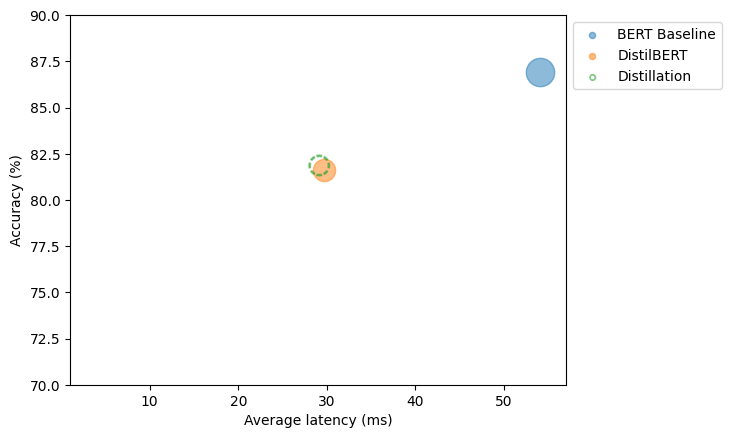

In [21]:
plot_metrics(perf_metrics,optim_type)

# Quantization

In [23]:
from torch.quantization import quantize_dynamic

model= AutoModelForSequenceClassification.from_pretrained(distilled_ckpt).to("cpu")
tokenizer=AutoTokenizer.from_pretrained(distilled_ckpt)

model_quantized=quantize_dynamic(model,{nn.Linear},dtype=torch.qint8)

pipe=pipeline("text-classification",model=model_quantized,tokenizer=tokenizer)
optim_type="Distillation + Quantization"
pb=PerformanceBenchmark(pipe,dataset['test'],optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 132.39
Average latency (ms) - 15.86 +\-1.05
Accuracy on test set - 0.819


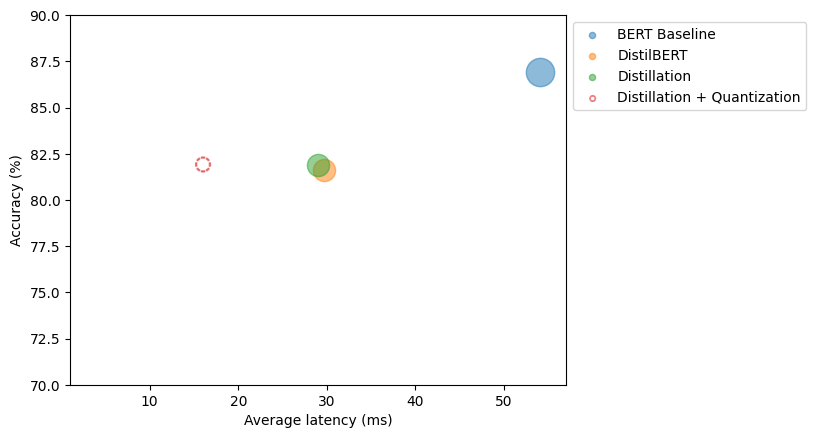

In [24]:
plot_metrics(perf_metrics,optim_type)

# ONNX + ORT

In [25]:
os.environ["OMP_NUM_THREADS"]=f"{cpu_count()}"
os.environ["OMP_WAIT_POLICY"]="ACTIVE"

In [26]:
onnx_model_path=Path("onnx/model.onnx")
convert(framework="pt",model=distilled_ckpt,tokenizer=tokenizer,
       output=onnx_model_path, opset=12, pipeline_name="text-classification")

ONNX opset version set to: 12
Loading pipeline (model: HuggingPanda/distilbert-base-uncased-distilled-clinc, tokenizer: DistilBertTokenizerFast(name_or_path='HuggingPanda/distilbert-base-uncased-distilled-clinc', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, 

In [27]:
def create_model_for_provider(model_path,provider="CPUExecutionProvider"):
    options=SessionOptions()
    options.intra_op_num_threads=1
    options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL
    session = InferenceSession(str(model_path), options, providers=[provider])
    session.disable_fallback()
    return session

onnx_model=create_model_for_provider(onnx_model_path)

In [28]:
inputs=tokenized_datasets['test'][:1]
del inputs['labels']
logits_onnx=onnx_model.run(None,inputs)[0]
print(logits_onnx.shape)
print(np.argmax(logits_onnx))
print(tokenized_datasets['test']['labels'][0])

(1, 151)
61
61


In [29]:
from onnxruntime.quantization import quantize_dynamic,QuantType

class OnnxPipeline:
    def __init__(self,model,tokenizer):
        self.model=model
        self.tokenizer=tokenizer
        
    def __call__(self,query):
        model_inputs=self.tokenizer(query,return_tensors="pt")
        input_onnx= {k:v.cpu().detach().numpy() for k,v in model_inputs.items()}
        logits= self.model.run(None, input_onnx)[0][0,:]
        probs=softmax(logits)
        pred_idx= np.argmax(probs).item()
        return [{
            "label":intents.int2str(pred_idx),
            "score":probs[pred_idx]
        }]
query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in
Paris and I need a 15 passenger van"""
pipe=OnnxPipeline(onnx_model,tokenizer)
pipe(query)

[{'label': 'car_rental', 'score': 0.9349354}]

In [30]:
class OnnxPerformanceBenchmark(PerformanceBenchmark):
    def __init__ (self,*args,model_path,**kwargs):
        super().__init__(*args,**kwargs)
        self.model_path=model_path
        
    def compute_size(self):
        size_mb=Path(self.model_path).stat().st_size /(1024*1024)
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

In [31]:
optim_type="Distillation + ORT"
pb = OnnxPerformanceBenchmark(pipe,dataset['test'],optim_type, model_path="onnx/model.onnx")
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.98
Average latency (ms) - 25.94 +\-1.22
Accuracy on test set - 0.819


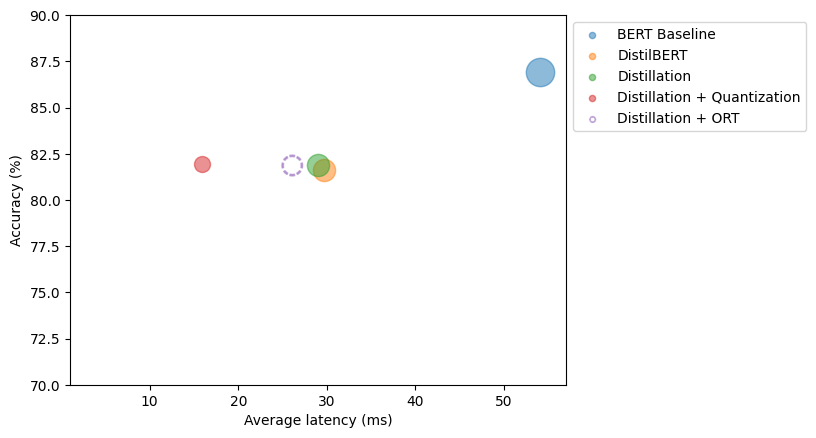

In [32]:
plot_metrics(perf_metrics,optim_type)

In [33]:
model_input = "onnx/model.onnx"
model_output = "onnx/model.quant.onnx"

quantize_dynamic(model_input,model_output,weight_type=QuantType.QInt8)

In [34]:
onnx_quantized_model = create_model_for_provider(model_output)
pipe= OnnxPipeline(onnx_quantized_model, tokenizer)
optim_type = "Distillation + ORT(quantized)"
pb = OnnxPerformanceBenchmark(pipe,dataset['test'],optim_type, model_path=model_output)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 64.36
Average latency (ms) - 14.29 +\-0.40
Accuracy on test set - 0.820


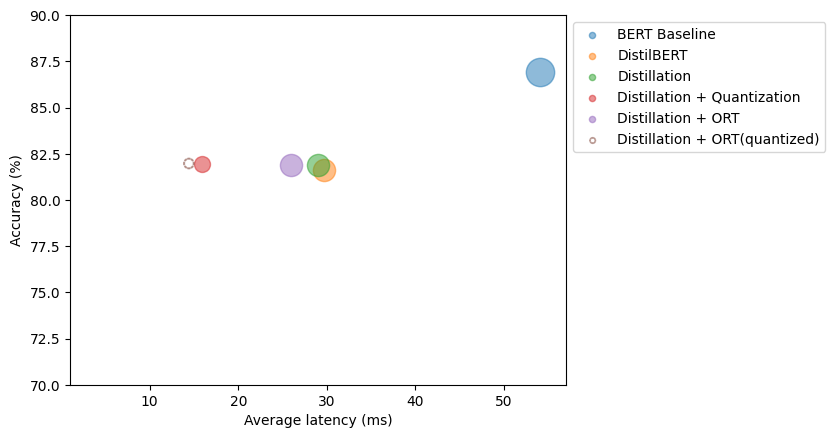

In [35]:
plot_metrics(perf_metrics,optim_type)

In [36]:
perf_metrics

{'BERT Baseline': {'size_mb': 418.1471004486084,
  'time_avg_ms': 54.07793522700018,
  'time_std_ms': 7.138766988641359,
  'accuracy': 0.8692727272727273},
 'DistilBERT': {'size_mb': 255.88184547424316,
  'time_avg_ms': 29.645230252000715,
  'time_std_ms': 3.7333191622112243,
  'accuracy': 0.8163636363636364},
 'Distillation': {'size_mb': 255.88184547424316,
  'time_avg_ms': 29.015513647996386,
  'time_std_ms': 1.3887222170220896,
  'accuracy': 0.8190909090909091},
 'Distillation + Quantization': {'size_mb': 132.39113807678223,
  'time_avg_ms': 15.86255333199608,
  'time_std_ms': 1.049735025059089,
  'accuracy': 0.8194545454545454},
 'Distillation + ORT': {'size_mb': 255.97955703735352,
  'time_avg_ms': 25.9390088939997,
  'time_std_ms': 1.220797106930619,
  'accuracy': 0.8190909090909091},
 'Distillation + ORT(quantized)': {'size_mb': 64.35916042327881,
  'time_avg_ms': 14.286920658000327,
  'time_std_ms': 0.40033532105624703,
  'accuracy': 0.82}}